# Attempt to Model Velocity Dependence
Attempt to model the change in stopping force as a function of velocity

In [1]:
%matplotlib inline
import os
import sys
sys.path.append(f"{os.getcwd()}/../")
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np

## Load in Data
Read in data from all velocities, and a new featurizer

In [22]:
data = pd.read_pickle(os.path.join('..', 'training_data.pkl.gz'))
data2 = pd.read_pickle("/scratch/users/pdanie20/silicon/PD-stopping-power-ml/training_data.pkl.gz")
# print(data['directory'].unique(), len(data['directory'].unique()))
# print(data2['directory'].unique(), len(data2['directory'].unique()))
# print('Total {} training entries'.format(len(data)))
for directory in data['directory'].unique():
    count = len(data[data['directory'] == directory])
    directory2 = f"data_silicon/{directory}"
    count2 = len(data2[data2['directory'] == directory2])
    print(f"{directory}: {count} {count2}")

data = pd.read_pickle("/scratch/users/pdanie20/silicon/PD-stopping-power-ml/training_data.pkl.gz")

silicon_data/2_Electronic_Stopping/H_Si/LDA_H_off_channel/v_0.5: 4200 4200
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_off_channel/v_1.5: 1400 1400
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_off_channel/v_3.0: 700 700
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_10.0: 365 365
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_2.0: 1824 1824
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_1.0: 3647 3647
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_7.5: 486 486
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_0.75: 4863 4863
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_4.0: 912 912
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_1.5: 2432 2432
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_3.0: 1216 1216
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_13.0: 281 281
silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/v_5.0: 729 729
silicon_data/2

In [3]:
with open('featurizer.pkl', 'rb') as fp:
    featurizer = pkl.load(fp)

In [4]:
start_frame = pkl.load(open(os.path.join('..', 'Si_starting_frame.pkl'), 'rb'))

## Separate Channel and Random Trajectories
Let's train first on the random trajectories as a starting point

In [23]:
# patterns = [
#     r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction/',
#     r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_011_direction/',
#     r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/',
# ]

# # Combine the patterns into a single regex pattern
# combined_pattern = '|'.join(patterns)

# #pattern = r'silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction'
# channel_data = data[data['directory'].str.contains(combined_pattern, regex=True)]
# print('Selected {} training entries'.format(len(channel_data)))

traj001 = data[data['directory'].str.contains('silicon_data/2_Electronic_Stopping/H_Si/LDA_H_001_direction/')]
traj011 = data[data['directory'].str.contains('silicon_data/2_Electronic_Stopping/H_Si/LDA_H_011_direction/')]
traj111 = data[data['directory'].str.contains('silicon_data/2_Electronic_Stopping/H_Si/LDA_H_111_direction/')]

Get the random trajecotries

In [24]:
# random_data = data[data['directory'].str.contains('silicon_data/2_Electronic_Stopping/H_Si/LDA_H_off_channel')]
random_data = pd.concat([data[data['directory'].str.contains('LDA_H_off_channel_12ePP')], data[data['directory'].str.contains('LDA_H_off_channel/v_0.5')]])
print(random_data['directory'].unique())
print('Selected {} training entries'.format(len(random_data)))

['data_silicon/silicon_data/2_Electronic_Stopping/H_Si/12epp/LDA_H_off_channel_12ePP/v_4.0'
 'data_silicon/silicon_data/2_Electronic_Stopping/H_Si/12epp/LDA_H_off_channel_12ePP/v_13.0'
 'data_silicon/silicon_data/2_Electronic_Stopping/H_Si/12epp/LDA_H_off_channel_12ePP/v_3.0'
 'data_silicon/silicon_data/2_Electronic_Stopping/H_Si/12epp/LDA_H_off_channel_12ePP/v_5.0'
 'data_silicon/silicon_data/2_Electronic_Stopping/H_Si/12epp/LDA_H_off_channel_12ePP/v_1.5'
 'data_silicon/silicon_data/2_Electronic_Stopping/H_Si/12epp/LDA_H_off_channel_12ePP/v_10.0'
 'data_silicon/silicon_data/2_Electronic_Stopping/H_Si/12epp/LDA_H_off_channel_12ePP/v_2.0'
 'data_silicon/silicon_data/2_Electronic_Stopping/H_Si/12epp/LDA_H_off_channel_12ePP/v_7.5'
 'data_silicon/silicon_data/2_Electronic_Stopping/H_Si/LDA_H_off_channel/v_0.5']
Selected 114200 training entries


## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

False
False
False
False
False
False
False
False
False


Text(0, 0.5, 'Force')

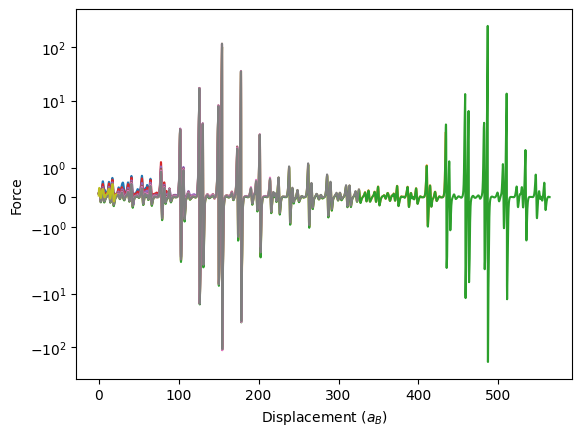

In [10]:
fig, ax = plt.subplots()

plot_max = 3000
for gid, group in random_data.groupby('directory'):
    print(group['force'].isna().any())
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid)

#ax.legend(ncol=2)
ax.set_yscale('symlog')
    
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

False
False
False
False
False
False
False
False
False
False
False
False
False


Text(0, 0.5, 'Force')

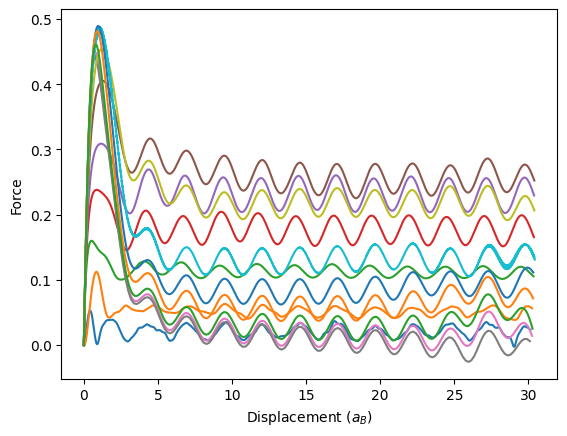

In [25]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in traj001.groupby('directory'):
    print(group['force'].isna().any())
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

# ax.set_xlim(0, 10)

# ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

False
False
False
False
False
False
False
False
False
False
False
False
False


Text(0, 0.5, 'Force')

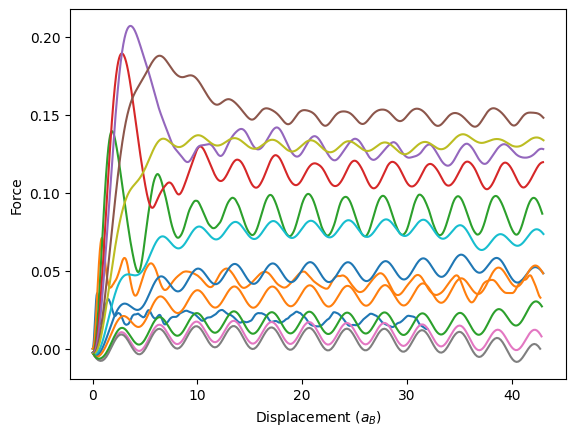

In [26]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in traj011.groupby('directory'):
    print(group['force'].isna().any())
    ax.plot(group['displacement'].iloc[1:plot_max], group['force'].iloc[1:plot_max], label=gid[3:].replace("_","="))

# ax.set_xlim(0, 10)

# ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

False
False
False
False
False
False
False
False
False
False


Text(0, 0.5, 'Force')

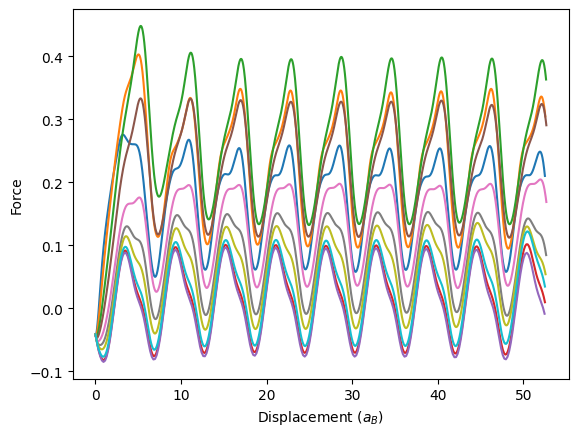

In [27]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in traj111.groupby('directory'):
    print(group['force'].isna().any())
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

# ax.set_xlim(0, 10)

# ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

Andre uses 6 $a_B$

for 001, 011 and 111 direction, let's average over the second repeat

In [28]:
random_data.query('displacement >= 6', inplace=True)

super_cell_lattice = start_frame.cell[0, 0] 
unit_cell_lattice = super_cell_lattice/3
print(super_cell_lattice, unit_cell_lattice)

channel_data = pd.concat([traj001[(traj001['displacement'] >= unit_cell_lattice) & (traj001['displacement'] < 2*unit_cell_lattice)], 
                          traj011[(traj011['displacement'] >= unit_cell_lattice*np.sqrt(2)) & (traj011['displacement'] < unit_cell_lattice*2*np.sqrt(2))], 
                          traj111[(traj111['displacement'] >= unit_cell_lattice*np.sqrt(3)) & (traj111['displacement'] < unit_cell_lattice*2*np.sqrt(3))]])

30.469 10.156333333333334


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


Text(0, 0.5, 'Force')

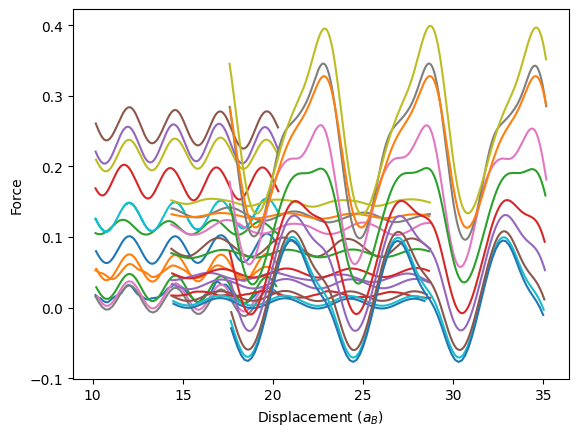

In [29]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in channel_data.groupby('directory'):
    print(group['force'].isna().any())
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

# ax.set_xlim(0, 10)

# ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

## Generate Features
Use the same features at the Al model

In [30]:
X_cols = featurizer.feature_labels()
y_col = 'force'

## Save Data
Save the training set used by this model

In [31]:
random_data.to_pickle(os.path.join('data', 'random_traj.pkl'))

In [32]:
channel_data.to_pickle(os.path.join('data', 'channel_traj.pkl'))